Principal components analysis (PCA) is a mainstay of population genetics, providing a model-free method for exploring patterns of relatedness within a collection of individuals. PCA was introduced as a tool for genetic genetic analysis by [Patterson, Price & Reich (2006)](http://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.0020190). Subsequently [Gil McVean (2009)](http://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1000686) provided an analytical framework for understanding PCA in terms of genetic ancestry. However, although PCA is widely used and the analytical details are worked out, there are a number of practical issues that come up when trying to run PCA on large SNP datasets from next-generation sequencing experiments. For example, small changes in how you prepare the input data can make a big difference to the outputs. The [Ag1000G phase 1 data](http://www.malariagen.net/data/ag1000g-phase1-ar3) provide a concrete illustration of some of these issues, so I thought I'd try to bring together some experiences here.

Also, while PCA is fairly quick to run on smaller datasets, it can become slow and memory-intensive with larger data. A few months ago I discovered that [scikit-learn](http://scikit-learn.org/stable/) includes a [randomized SVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.RandomizedPCA.html) implementation, which is a potentially faster and more scalable method for approximating the top N components than using a conventional singular value decomposition. To evaluate randomized PCA I implemented some functions in [scikit-allel](http://scikit-allel.readthedocs.org) which provide a convenience layer between underlying SVD implementations in NumPy and scikit-learn and the typical data structures I used to store genotype data. I know others have also started working with randomized PCA for genotype data ([Galinsky et al. 2015](http://biorxiv.org/content/early/2015/04/16/018143)) so I thought it would be interesting to apply both conventional and randomized SVD implementations to a non-human dataset and report some performance data.

## Setup

In [1]:
import random
random.seed(42)
import time
import numpy as np
np.random.seed(42)
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
import bcolz
import pandas
import allel; print('scikit-allel', allel.__version__)
%reload_ext memory_profiler

scikit-allel 1.0.3


I have a copy of the [Ag1000G phase 1 AR3 data release](http://www.malariagen.net/data/ag1000g-phase1-ar3) on a local drive. The SNP genotype data is available in an HDF5 file.

In [2]:
callset_fn = 'data/2015-09-28/ag1000g.phase1.ar3.pass.h5'
callset = h5py.File(callset_fn, mode='r')
callset

<HDF5 file "ag1000g.phase1.ar3.pass.h5" (mode r)>

Let's work with chromosome arm 3L.

In [3]:
chrom = '3L'

Setup the genotype data.

In [4]:
g = allel.GenotypeChunkedArray(callset[chrom]['calldata']['genotype'])
g

<GenotypeChunkedArray shape=(9643193, 765, 2) dtype=int8 chunks=(6553, 10, 2)
   nbytes=13.7G cbytes=548.0M cratio=25.7
   compression=gzip compression_opts=3
   values=h5py._hl.dataset.Dataset>

Count alleles at each variant. This takes a minute or so.

In [5]:
# the '[:]' syntax pulls the data from compressed storage into a numpy array
ac = g.count_alleles()[:]
ac

<AlleleCountsArray shape=(9643193, 4) dtype=int32>
1527    3    0    0
1529    1    0    0
1528    2    0    0
...
1512   16    0    0
1527    1    0    0
1507   18    1    0

Before going any further, I'm going to remove singletons and multiallelic SNPs. Singletons are not informative for PCA, and the analysis is simpler if we restrict to biallelic SNPs.

For interest, how many multiallelic SNPs are there?

In [6]:
np.count_nonzero(ac.max_allele() > 1)

2193707

How many biallelic singletons?

In [7]:
np.count_nonzero((ac.max_allele() == 1) & ac.is_singleton(1))

2622060

Apply the filtering.

In [8]:
flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1)
gf = g.compress(flt, axis=0)
gf

<GenotypeChunkedArray shape=(4825329, 765, 2) dtype=int8 chunks=(590, 765, 2)
   nbytes=6.9G cbytes=442.8M cratio=15.9
   compression=blosc compression_opts={'shuffle': 1, 'cname': 'lz4', 'clevel': 5}
   values=zarr.core.Array>

Finally, transform the genotype data into a 2-dimensional matrix where each cell has the number of non-reference alleles per call. This is what we'll use as the input to PCA.

In [9]:
gn = gf.to_n_alt()
gn

<ChunkedArrayWrapper shape=(4825329, 765) dtype=int8 chunks=(1179, 765)
   nbytes=3.4G cbytes=331.4M cratio=10.6
   compression=blosc compression_opts={'shuffle': 1, 'cname': 'lz4', 'clevel': 5}
   values=zarr.core.Array>

Note that we are still working with reasonably large amounts of data here, and so we are using chunked compressed arrays for storage. The `gn` variable above uses a [Zarr](http://zarr.readthedocs.io) array to store the data, one of several chunked storage containers that can be used with scikit-allel.

## Removing correlated features (LD pruning)

As I understand it, PCA works best when the features you provide as input are independent from each other. Here each SNP is a feature, however, because DNA is transmitted from one generation to the next with some recombination between parents, genotypes at nearby SNPs tend to be correlated, with the correlation (linkage disequlibrium) decaying as you increase the separation between SNPs.

We can get a sense of that correlation structure by visualising pairwise linkage disequilibrium in the first 1000 SNPs.

In [10]:
def plot_ld(gn, title):
    m = allel.stats.rogers_huff_r(gn) ** 2
    ax = allel.plot.pairwise_ld(m)
    ax.set_title(title)

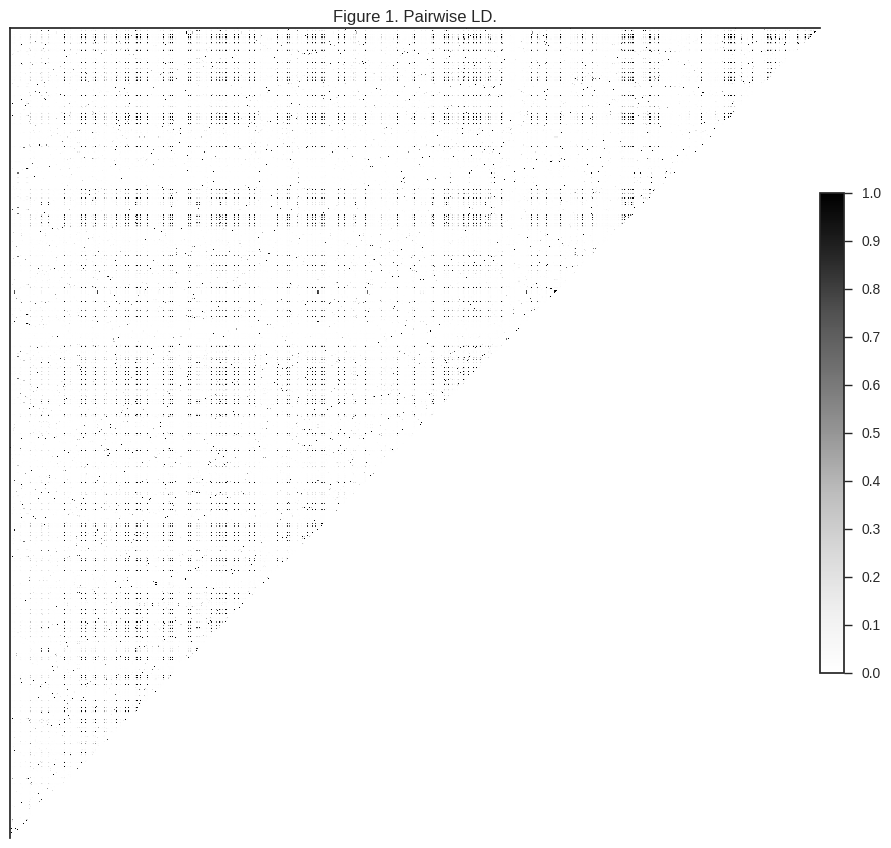

In [11]:
plot_ld(gn[:1000], 'Figure 1. Pairwise LD.')

The darker regions in the plot above indicate pairs of SNPs where genotypes are correlated.

Before I deal with this correlation directly, I'm going to thin down the data a bit. There are 4,825,329 SNPs left after the initial filtering steps above, and analysing this many features would be slow. Here we are more concerned with running an exploratory analysis, so I'm going to randomly choose a subset of these SNPs to work with. This should still reveal the main signals in the data, while making runtime faster. 

In [12]:
n = 100000  # number of SNPs to choose randomly
vidx = np.random.choice(gn.shape[0], n, replace=False)
vidx.sort()
gnr = gn.take(vidx, axis=0)
gnr

<ChunkedArrayWrapper shape=(100000, 765) dtype=int8 chunks=(391, 765)
   nbytes=73.0M cbytes=7.1M cratio=10.3
   compression=blosc compression_opts={'shuffle': 1, 'cname': 'lz4', 'clevel': 5}
   values=zarr.core.Array>

By randomly downsampling SNPs, this should have dealt with much of the correlation between nearby features. Let's take a look at the first 1000.

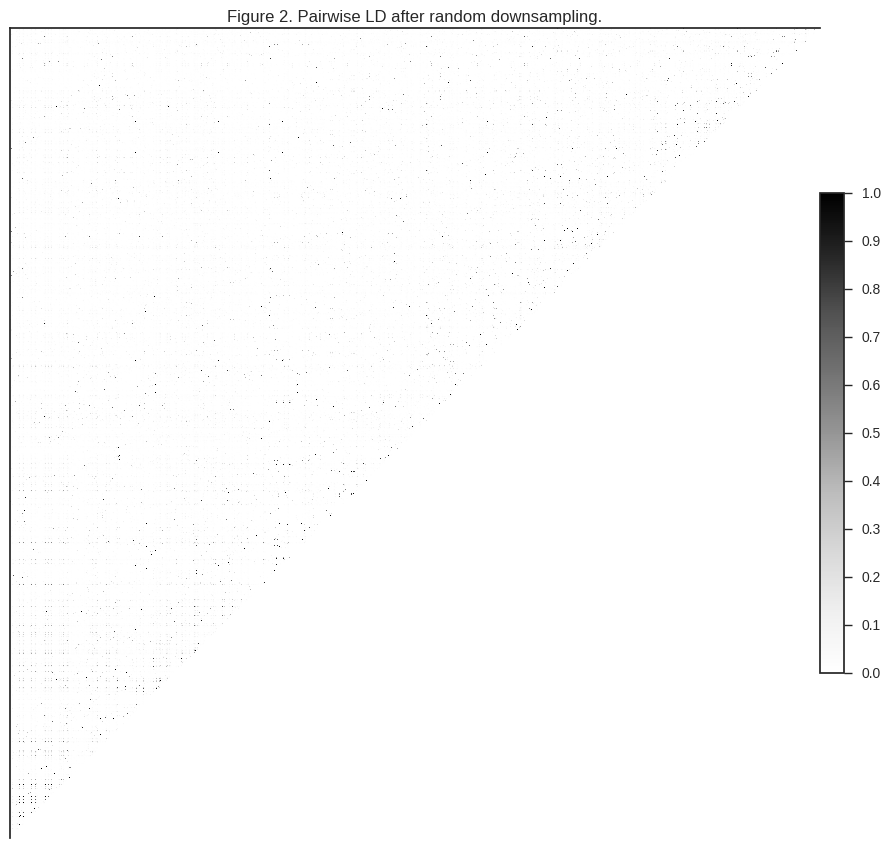

In [13]:
plot_ld(gnr[:1000], 'Figure 2. Pairwise LD after random downsampling.')

You can see that much of the correlation is gone. However, depending how dusty your screen is, you may be able to see some speckling, indicating that there are still some correlated SNPs in the dataset.

To remove this remaining correlation, I'm going to explicitly locate SNPs that are not correlated with each other, using the `locate_unlinked` function from scikit-allel. This is known as LD pruning, and works by sliding a window along the data, computing pairwise LD between all SNPs within each window, then removing one SNP from each correlated pair.

Conventionally, LD pruning is run just once, however I'm going to run several iterations. In some cases this may make a difference to the results, in others it may not, probably depending on how much long-range LD is present in your samples. Running multiple iterations does slow things down a bit, but it's interesting to demonstrate and see what the effect is.

In [14]:
def ld_prune(gn, size, step, threshold=.1, n_iter=1):
    for i in range(n_iter):
        loc_unlinked = allel.locate_unlinked(gn, size=size, step=step, threshold=threshold)
        n = np.count_nonzero(loc_unlinked)
        n_remove = gn.shape[0] - n
        print('iteration', i+1, 'retaining', n, 'removing', n_remove, 'variants')
        gn = gn.compress(loc_unlinked, axis=0)
    return gn

In [15]:
gnu = ld_prune(gnr, size=500, step=200, threshold=.1, n_iter=5)

iteration 1 retaining 56651 removing 43349 variants
iteration 2 retaining 47465 removing 9186 variants
iteration 3 retaining 44583 removing 2882 variants
iteration 4 retaining 43266 removing 1317 variants
iteration 5 retaining 42509 removing 757 variants


5 iterations is probably more than necessary for this dataset, as you can see not many SNPs are removed after the first few iterations.

I've used a sliding window size of 500 SNPs here, which is larger than others typically use. Out of interest, how many SNPs would be removed if we used a smaller window and just one iteration?

In [16]:
ld_prune(gnr, size=100, step=20, threshold=.1, n_iter=1);

iteration 1 retaining 75762 removing 24238 variants


So with this dataset, using a larger window and multiple iterations finds and removes a lot more correlated SNPs. This is probably related to the fact that there are a lot of rare variants in the data, and so a larger window is required to find variants in linkage.

Let's take a look at how much LD is left after LD pruning.

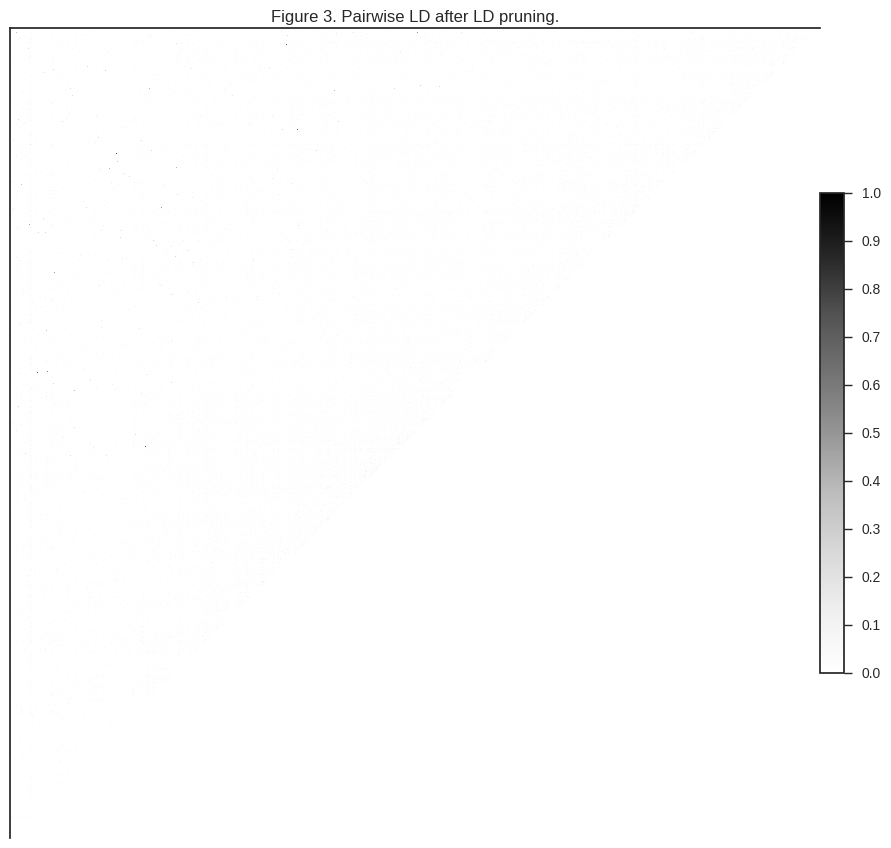

In [17]:
plot_ld(gnu[:1000], 'Figure 3. Pairwise LD after LD pruning.')

The data are relatively small now after downsampling and LD-pruning, so we can bring the data out of chunked storage and into memory uncompressed, which is necessary for PCA.

In [18]:
gnu = gnu[:]
gnu

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

## PCA via conventional SVD

Let's run a conventional PCA analysis of the LD-pruned genotype data.

In [19]:
coords1, model1 = allel.pca(gnu, n_components=10, scaler='patterson')

To help visualise the results, I need to pull in some metadata about which population each individual mosquito belongs to.

In [20]:
df_samples = pandas.read_csv('data/2015-09-28/samples.meta.txt', delimiter='\t', index_col='index')
df_samples.head()

,ox_code,src_code,sra_sample_accession,population,country,region,contributor,contact,year,m_s,sex,n_sequences,mean_coverage,latitude,longitude
index,,,,,,,,,,,,,,,
0,AB0085-C,BF2-4,ERS223996,BFS,Burkina Faso,Pala,Austin Burt,Sam O'Loughlin,2012,S,F,89905852,28.01,11.150,-4.235
1,AB0087-C,BF3-3,ERS224013,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,116706234,36.76,11.233,-4.472
2,AB0088-C,BF3-5,ERS223991,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,112090460,23.30,11.233,-4.472
3,AB0089-C,BF3-8,ERS224031,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,145350454,41.36,11.233,-4.472
4,AB0090-C,BF3-10,ERS223936,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,105012254,34.64,11.233,-4.472


In [21]:
populations = df_samples.population.unique()
populations

array(['BFS', 'BFM', 'UGS', 'GWA', 'KES', 'CMS', 'AOM', 'GAS', 'GNS'], dtype=object)

In [22]:
pop_colours = {
    'BFM': '#FF0000',
    'GAS': '#008000',
    'GNS': '#00FFFF',
    'UGS': '#90EE90',
    'GWA': '#FFA500',
    'AOM': '#8B0000',
    'BFS': '#1E90FF',
    'KES': '#808080',
    'CMS': '#0000FF',
}

In [23]:
def plot_pca_coords(coords, model, pc1, pc2, ax, sample_population):
    sns.despine(ax=ax, offset=5)
    x = coords[:, pc1]
    y = coords[:, pc2]
    for pop in populations:
        flt = (sample_population == pop)
        ax.plot(x[flt], y[flt], marker='o', linestyle=' ', color=pop_colours[pop], 
                label=pop, markersize=6, mec='k', mew=.5)
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))
    

def fig_pca(coords, model, title, sample_population=None):
    if sample_population is None:
        sample_population = df_samples.population.values
    # plot coords for PCs 1 vs 2, 3 vs 4
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 2, 1)
    plot_pca_coords(coords, model, 0, 1, ax, sample_population)
    ax = fig.add_subplot(1, 2, 2)
    plot_pca_coords(coords, model, 2, 3, ax, sample_population)
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    fig.suptitle(title, y=1.02)
    fig.tight_layout()
    

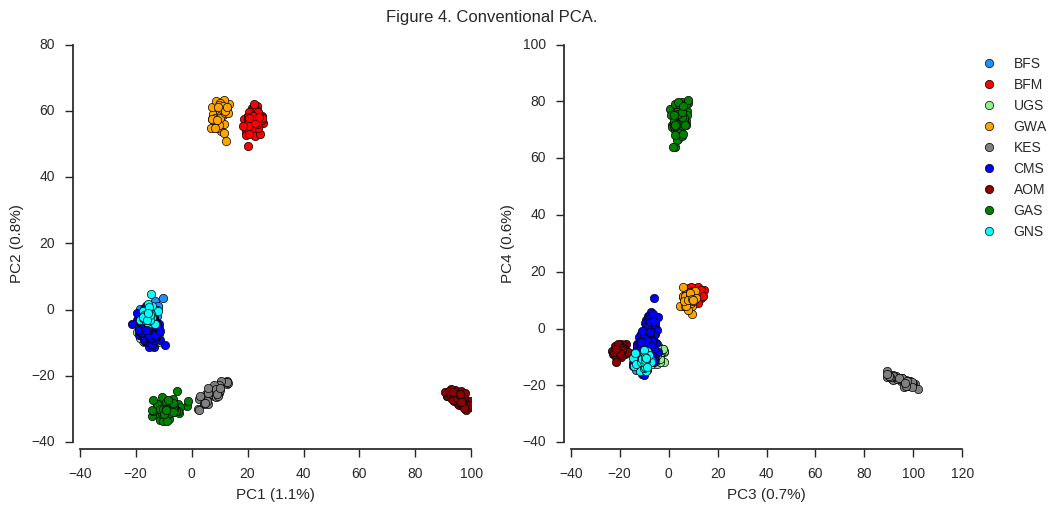

In [24]:
fig_pca(coords1, model1, 'Figure 4. Conventional PCA.')

Looking at the left-hand plot of PC1 versus PC2, there is a clear separation of individuals into 6 different clusters. This indicates there are at least 6 genetically distinct populations represented by the mosquitoes we've sequenced. The plot of PC3 vs PC4 gives us additional evidence that certain populations (GAS and KES) are genetically distinct from each other and the rest, but doesn't reveal any new clusters.

## Effect of LD pruning

What would happen if we ran PCA on the data **without** removing correlated SNPs?

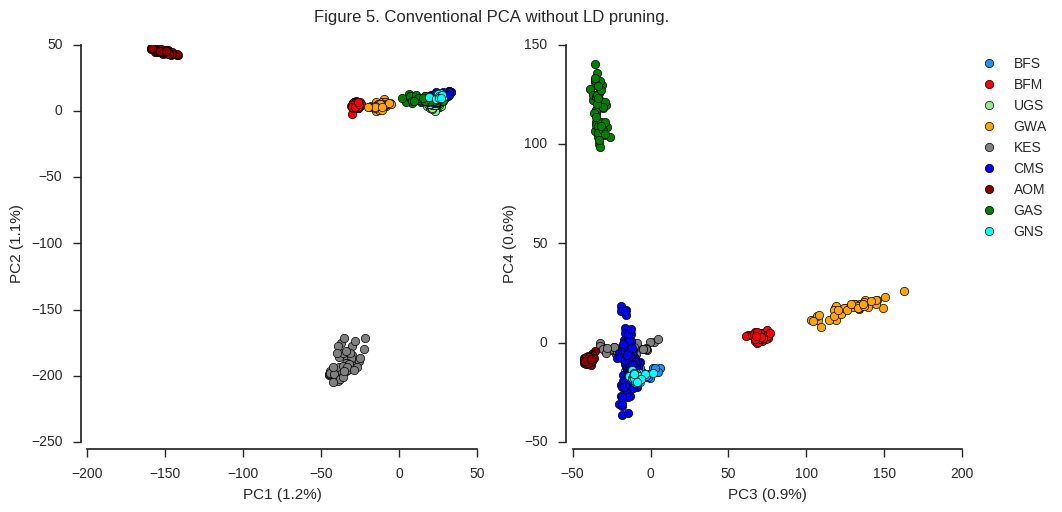

In [25]:
coords2, model2 = allel.pca(gnr, n_components=10, scaler='patterson')
fig_pca(coords2, model2, 'Figure 5. Conventional PCA without LD pruning.')

Although all of the same population sub-divisions are visible in the first four components, they are resolved in a very different way. The first two components are now driven strongly by two populations, Angola (AOM) and Kenya (KES), and further population structure is not clearly resolved until PC3 and PC4. 

It is interesting to note that the Kenyan and Angolan populations are the two populations with the lowest heterozygosity. In particular, almost all Kenyan samples have very long runs of homozygosity, suggesting a recent population crash. I would hazard a guess that, in particular for Kenya, there is long-range LD which is affecting the PCA. When we used the aggressively LD-pruned data in Figure 4 above, this effect is reduced.

## Effect of scaling

Patterson et al. (2006) proposed scaling the data to unit variance at each SNP, assuming that the alleles are approximately binomially distributed. McVean (2009) remarks that scaling the data in this way should have little effect, although it will upweight rare variants (i.e., SNPs where the minor allele is at low frequency in the dataset). Let's return to using the LD pruned data, and see what happens if we **don't** use Patterson's scaling method but instead just centre the data.

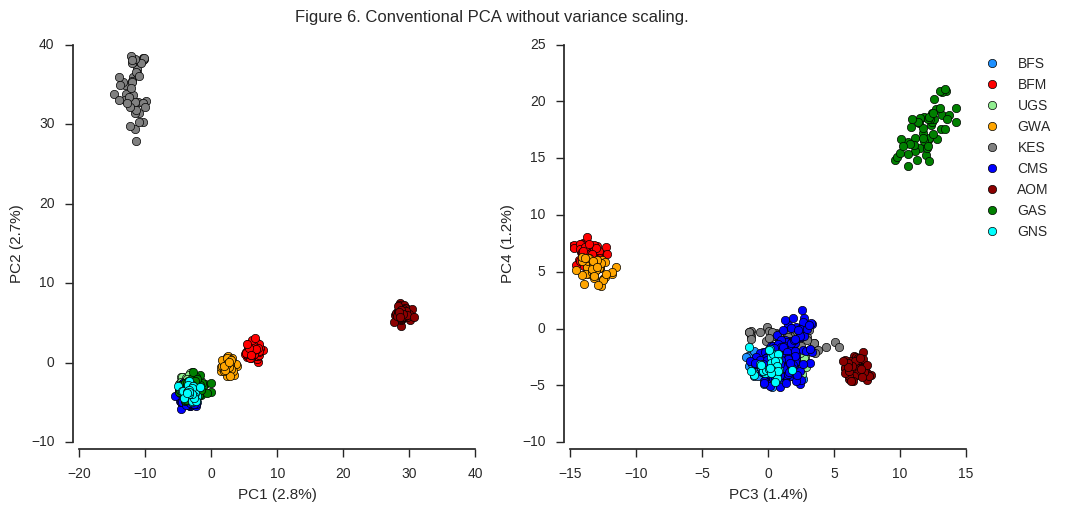

In [26]:
coords3, model3 = allel.pca(gnu, n_components=10, scaler=None)
fig_pca(coords3, model3, 'Figure 6. Conventional PCA without variance scaling.')

Here again the same clusters are visible but are resolved in a different way. Also, note more of the total variance is explained by the first four components than when using the Patterson scaler. As McVean (2009) suggests, I would guess that these effects are both due to the weighting of rare variants. When rare variants are upweighted, this resolves more clearly any subtle population structure in the data. However, there a lot of rare variants in this dataset, and so the total amount of variance explained by the first few components goes down.

## Effect of unequal sample sizes

McVean (2009) provides a very elegant demonstration of what can happen if different populations are not equally represented in your dataset. If there are many more samples from one particular population, this has the effect of warping the principal components. 

In Ag1000G phase one there are a lot more samples from Cameroon (CMS) than any of the other locations.

In [27]:
df_samples.groupby('population').population.count()

population
AOM     60
BFM     69
BFS     81
CMS    275
GAS     56
GNS     31
GWA     46
KES     44
UGS    103
Name: population, dtype: int64

What would happen if we randomly pick a subset of CMS samples, to achieve a more even representation? 

In [28]:
sidx_cms = df_samples[df_samples.population == 'CMS'].index
sidx_other = df_samples[df_samples.population != 'CMS'].index
sidx = sorted(list(sidx_other) + random.sample(list(sidx_cms), 50))
len(sidx)

540

In [29]:
df_samples.take(sidx).groupby('population').population.count()

population
AOM     60
BFM     69
BFS     81
CMS     50
GAS     56
GNS     31
GWA     46
KES     44
UGS    103
Name: population, dtype: int64

In [30]:
gnus = gnu.take(sidx, axis=1)
# also remove any non-segregating variants after removing samples
gnus = gnus.compress(np.any(gnus > 0, axis=1) & np.any(gnus < 2, axis=1), axis=0)

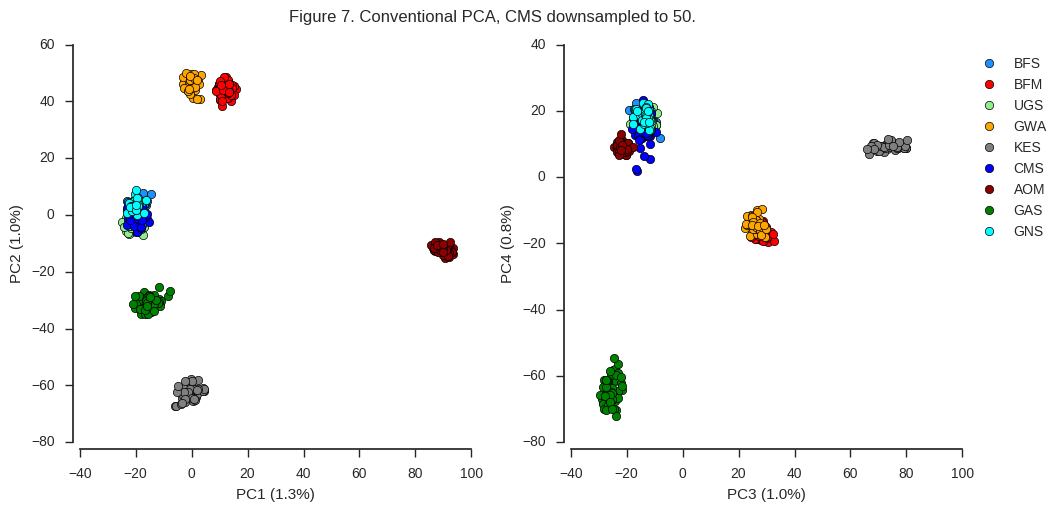

In [31]:
coords4, model4 = allel.pca(gnus, n_components=10, scaler='patterson')
fig_pca(coords4, model4, 'Figure 7. Conventional PCA, CMS downsampled to 50.', 
        sample_population=df_samples.take(sidx).population.values)

Now the results are similar to the original PCA we plotted in Figure 4, however PC2 appears to be more balanced. So sample size clearly does matter. However, there is a chicken-and-egg problem here. If you are using PCA to discover population structure in some collection of individuals, you won't know *a priori* if any particular population is overrepresented. Perhaps in that situation, an initial round of PCA to discover population structure can be followed up with a second round, downsampling any populations within which you observe no differentiation.

## Randomized PCA

Randomized PCA is an alternative to conventional PCA. I don't claim to understand the details, but apparently it uses an approximation to estimate the top principal components only, rather than evaluating all principal components as in a conventional SVD. So it should be faster and use less memory. 

Let's run a randomized PCA on the Ag1000G data and compare the results with the conventional PCA.

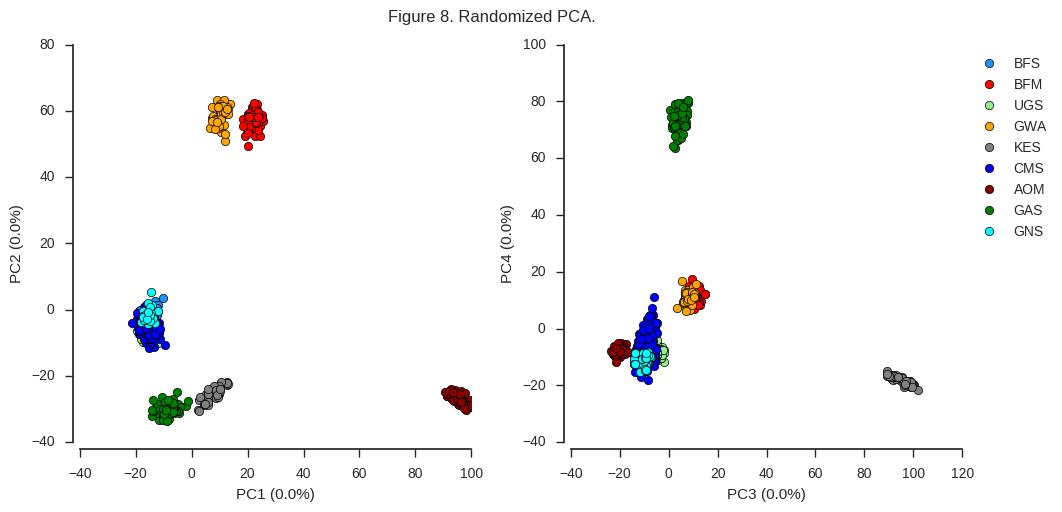

In [32]:
coords5, model5 = allel.randomized_pca(gnu, n_components=10, scaler='patterson')
fig_pca(coords5, model5, 'Figure 8. Randomized PCA.')

For the first four components at least, the results are indistinguishable from the conventional PCA.

Let's compare performance.

In [33]:
n_variants = np.arange(5000, gnu.shape[0], 5000)

pca_time_v = []
for n in n_variants:
    gx = gnu[:n]
    t1 = time.time()
    allel.stats.pca(gx, n_components=10, scaler='patterson')
    t2 = time.time()
    dur = t2-t1
    pca_time_v.append(dur)

random_pca_time_v = []
for n in n_variants:
    gx = gnu[:n]
    t1 = time.time()
    allel.stats.randomized_pca(gx, n_components=10, scaler='patterson')
    t2 = time.time()
    dur = t2-t1
    random_pca_time_v.append(dur)
    

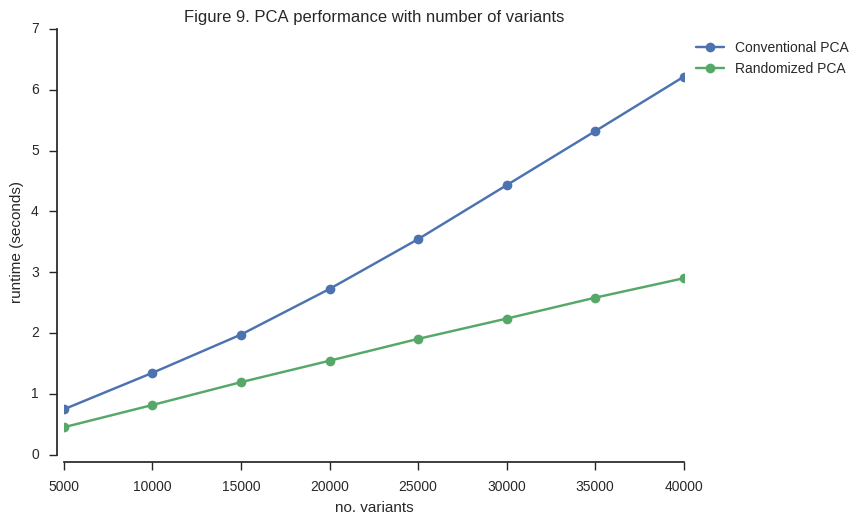

In [34]:
fig, ax = plt.subplots()
sns.despine(ax=ax, offset=5)
ax.plot(n_variants, pca_time_v, label='Conventional PCA', marker='o')
ax.plot(n_variants, random_pca_time_v, label='Randomized PCA', marker='o')
ax.set_xlabel('no. variants')
ax.set_ylabel('runtime (seconds)')
ax.legend(bbox_to_anchor=[1, 1], loc='upper left')
ax.set_title('Figure 9. PCA performance with number of variants');

In [35]:
n_samples = np.arange(50, gnu.shape[1], 50)

pca_time_s = []
for n in n_samples:
    gx = gnu[:, :n]
    gx = gx.compress(np.any(gx > 0, axis=1) & np.any(gx < 2, axis=1), axis=0)
    t1 = time.time()
    allel.pca(gx, n_components=10, scaler='patterson')
    t2 = time.time()
    dur = t2-t1
    pca_time_s.append(dur)

random_pca_time_s = []
for n in n_samples:
    gx = gnu[:, :n]
    gx = gx.compress(np.any(gx > 0, axis=1) & np.any(gx < 2, axis=1), axis=0)
    t1 = time.time()
    allel.randomized_pca(gx, n_components=10, scaler='patterson')
    t2 = time.time()
    dur = t2-t1
    random_pca_time_s.append(dur)
    

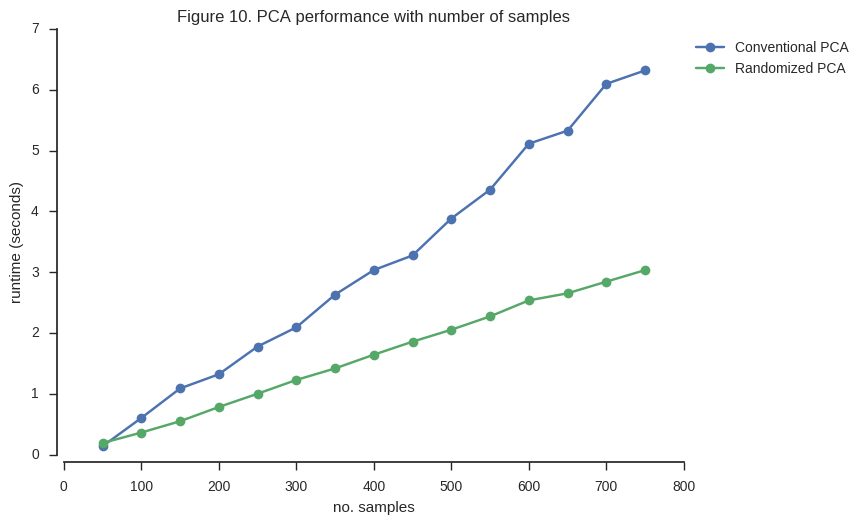

In [36]:
fig, ax = plt.subplots()
sns.despine(ax=ax, offset=5)
ax.plot(n_samples, pca_time_s, label='Conventional PCA', marker='o')
ax.plot(n_samples, random_pca_time_s, label='Randomized PCA', marker='o')
ax.set_xlabel('no. samples')
ax.set_ylabel('runtime (seconds)')
ax.legend(bbox_to_anchor=[1, 1], loc='upper left')
ax.set_title('Figure 10. PCA performance with number of samples');

What about memory usage?

In [37]:
%memit allel.pca(gnu, n_components=10, scaler='patterson');

peak memory: 3397.09 MiB, increment: 589.41 MiB


In [38]:
%memit allel.randomized_pca(gnu, n_components=10, scaler='patterson');

peak memory: 3148.99 MiB, increment: 310.09 MiB


So the randomized PCA is faster, scales better with more samples, and uses around half of the memory required by conventional SVD.

## Conclusions

* LD pruning makes a difference. For NGS data, a larger window size and/or multiple rounds of pruning may be required to deal with regions of long-range LD. LD pruning may also impact different populations in different ways, if populations have different levels of LD.
* Scaling input data to unit variance using the method of Patterson et al. (2006) makes a small but noticeable difference, increasing the ability to resolve distinct populations within higher principal components.
* Unequal sample sizes warps the principal components, as predicted by McVean (2009).
* Randomized PCA produces results that are almost indistinguishable from conventional PCA, while running faster and using less memory. However, preparing the data (LD pruning) can also take a long time, so it would be good to find a way to optimise that step too.

## Further reading

* Patterson, N., Price, A. L., & Reich, D. (2006). [Population structure and eigenanalysis](http://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.0020190). PLoS Genetics, 2(12), 2074–2093.
* McVean, G. (2009). [A genealogical interpretation of principal components analysis](http://doi.org/10.1371/journal.pgen.1000686). PLoS Genetics, 5(10), e1000686. 
* Galinsky, K. J., Bhatia, G., Loh, P.-R., Georgiev, S., Mukherjee, S., Patterson, N. J., & Price, A. L. (2015). [Fast principal components analysis reveals independent evolution of ADH1B gene in Europe and East Asia](http://biorxiv.org/content/early/2015/08/24/018143.abstract). bioRxiv.
* [`scikit-allel` PCA functions](http://scikit-allel.readthedocs.org/en/latest/stats/decomposition.html)

<hr/>

## Post-script: Randomized PCA and lower components

When I originally wrote this post, I only looked at the first four components. These account for most of the variance and so capture the major signals of population subdivision. 

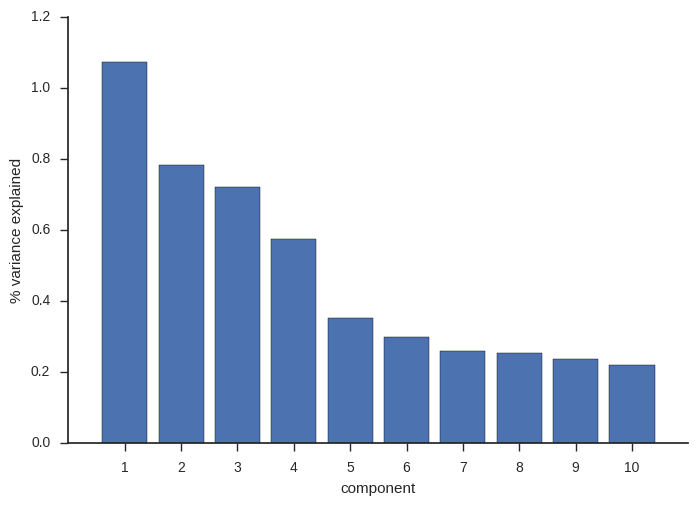

In [39]:
fig, ax = plt.subplots()
sns.despine(ax=ax)
x = np.arange(10)
y = model1.explained_variance_ratio_ * 100
ax.bar(x+.6, y, width=.8)
ax.set_xticks(x+1)
ax.set_xlim(0, 11)
ax.set_xlabel('component')
ax.set_ylabel('% variance explained');

For the first four components, conventional and randomized PCA are basically the same. However, recently I looked into the lower components, where there are some interesting signals of population structure, but less variance is captured. For these lower components, results from conventional and randomized PCA are not so similar.

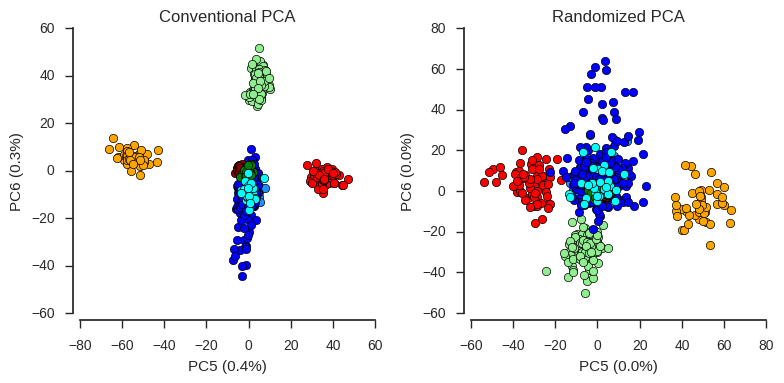

In [40]:
fig = plt.figure(figsize=(8, 4))

ax = fig.add_subplot(1, 2, 1)
plot_pca_coords(coords1, model1, 4, 5, ax=ax, sample_population=df_samples.population.values)
ax.set_title('Conventional PCA')

ax = fig.add_subplot(1, 2, 2)
plot_pca_coords(coords5, model5, 4, 5, ax=ax, sample_population=df_samples.population.values)
ax.set_title('Randomized PCA')

fig.tight_layout();

So an important caveat when using randomized PCA is that lower components may not be resolved very well, compared with conventional PCA.

## Post-script: OpenBLAS

The original version of this post was run with NumPy built without any linear algebra optimisations. Following a comment from Andreas Noack I have re-run this notebook with NumPy built with OpenBLAS. This significantly speeds up the runtime for both conventional and randomized PCA. With the data size used in this notebook, the bottleneck is now more data preparation (LD pruning) than running the PCA itself.

In [41]:
np.__config__.show()

openblas_lapack_info:
    libraries = ['openblas', 'openblas']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
    library_dirs = ['/home/aliman/miniconda3/envs/biipy240/lib']
blas_mkl_info:
  NOT AVAILABLE
blas_opt_info:
    libraries = ['openblas', 'openblas']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
    library_dirs = ['/home/aliman/miniconda3/envs/biipy240/lib']
openblas_info:
    libraries = ['openblas', 'openblas']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
    library_dirs = ['/home/aliman/miniconda3/envs/biipy240/lib']
lapack_opt_info:
    libraries = ['openblas', 'openblas']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
    library_dirs = ['/home/aliman/miniconda3/envs/biipy240/lib']


In [42]:
!lscpu

Architecture:          x86_64
CPU op-mode(s):        32-bit, 64-bit
Byte Order:            Little Endian
CPU(s):                8
On-line CPU(s) list:   0-7
Thread(s) per core:    2
Core(s) per socket:    4
Socket(s):             1
NUMA node(s):          1
Vendor ID:             GenuineIntel
CPU family:            6
Model:                 94
Model name:            Intel(R) Xeon(R) CPU E3-1505M v5 @ 2.80GHz
Stepping:              3
CPU MHz:               3317.453
CPU max MHz:           3700.0000
CPU min MHz:           800.0000
BogoMIPS:              5615.30
Virtualisation:        VT-x
L1d cache:             32K
L1i cache:             32K
L2 cache:              256K
L3 cache:              8192K
NUMA node0 CPU(s):     0-7
Flags:                 fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc art arch_perfmon pebs bts rep_good nopl xtopology nonstop_tsc aperfmperf eagerfpu pni 

In [43]:
import datetime
print(datetime.datetime.now().isoformat())

2016-11-01T19:57:14.214815
